# Chapter 8 (Pine): Curve Fitting Solutions

${\large\bf 1.}$ We linearize the equation $V(t)=V_0e^{\Gamma t}$ by taking the logarithm: $\ln V = \ln V_0 + \Gamma t$.  Comparing with the equation for a straight line $Y = A + BX$, we see that
$$
\begin{align}
Y &= \ln V \;,& X &= t \\
A &= \ln V_0\;,& B &= \Gamma
\end{align}
$$

$\bf{(a)}$ & $\bf{(c)}$ There are two parts to this problem: (1) writing the fitting function with $\chi^2$ weighting and (2) transforming the data to linear form so that it can be fit to an exponential.

The first part is done with the function ``LineFitWt(x, y, sig)``.  There is also an ancillary function ``rechisq(x, y, dy, slope, yint)`` that calcuates the reduced chi-squared $\chi_r^2$ for a particular set of data & fitting parameters.

The second part involves transforming the data and its uncertainties.  This is done following the procedure described in *Introduction to Python for Science (by Pine)* in $\S 8.1.1$.

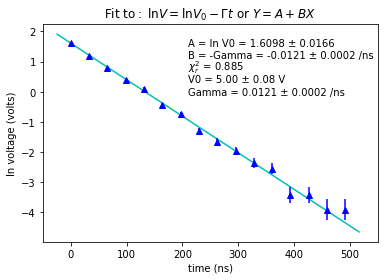

<Figure size 432x288 with 0 Axes>

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def LineFitWt(x, y, sig):
    """ 
    Returns slope and y-intercept of weighted linear fit to
    (x,y) data set.
    Inputs: x and y data array and uncertainty array (unc)
            for y data set.
    Outputs: slope and y-intercept of best fit to data and
             uncertainties of slope & y-intercept.
    """
    sig2 = sig ** 2
    norm = (1.0 / sig2).sum()
    xhat = (x / sig2).sum() / norm
    yhat = (y / sig2).sum() / norm
    slope = ((x - xhat) * y / sig2).sum() / ((x - xhat) * x / sig2).sum()
    yint = yhat - slope * xhat
    sig2_slope = 1.0 / ((x - xhat) * x / sig2).sum()
    sig2_yint = sig2_slope * (x * x / sig2).sum() / norm
    return slope, yint, np.sqrt(sig2_slope), np.sqrt(sig2_yint)


def redchisq(x, y, dy, slope, yint):
    chisq = (((y - yint - slope * x) / dy) ** 2).sum()
    return chisq / float(x.size - 2)


# Read data from data file
t, V, dV = np.loadtxt("data/RLcircuit.txt", skiprows=2, unpack=True)

########## Code to tranform & fit data starts here ##########

# Transform data and parameters from ln V = ln V0 - Gamma t
# to linear form: Y = A + B*X, where Y = ln V, X = t, dY = dV/V
X = t  # transform t data for fitting (not needed as X=t)
Y = np.log(V)  # transform N data for fitting
dY = dV / V  # transform uncertainties for fitting

# Fit transformed data X, Y, dY to obtain fitting parameters
# B & A.  Also returns uncertainties dA & dB in B & A
B, A, dB, dA = LineFitWt(X, Y, dY)
# Return reduced chi-squared
redchisqr = redchisq(X, Y, dY, B, A)

# Determine fitting parameters for original exponential function
# N = N0 exp(-Gamma t) ...
V0 = np.exp(A)
Gamma = -B
# ... and their uncertainties
dV0 = V0 * dA
dGamma = dB

###### Code to plot transformed data and fit starts here ######

# Create line corresponding to fit using fitting parameters
# Only two points are needed to specify a straight line
Xext = 0.05 * (X.max() - X.min())
Xfit = np.array([X.min() - Xext, X.max() + Xext])  # smallest & largest X points
Yfit = B * Xfit + A  # generates Y from X data &
# fitting function
plt.errorbar(X, Y, dY, fmt="b^")
plt.plot(Xfit, Yfit, "c-", zorder=-1)
plt.title(r"$\mathrm{Fit\ to:}\ \ln V = \ln V_0-\Gamma t$ or $Y = A + BX$")
plt.xlabel("time (ns)")
plt.ylabel("ln voltage (volts)")
plt.xlim(-50, 550)

plt.text(210, 1.5, u"A = ln V0 = {0:0.4f} \xb1 {1:0.4f}".format(A, dA))
plt.text(210, 1.1, u"B = -Gamma = {0:0.4f} \xb1 {1:0.4f} /ns".format(B, dB))
plt.text(210, 0.7, "$\chi_r^2$ = {0:0.3f}".format(redchisqr))
plt.text(210, 0.3, u"V0 = {0:0.2f} \xb1 {1:0.2f} V".format(V0, dV0))
plt.text(210, -0.1, u"Gamma = {0:0.4f} \xb1 {1:0.4f} /ns".format(Gamma, dGamma))

plt.show()
plt.savefig("RLcircuit.pdf")

$\bf{(b)}$ The value of $\chi_r^2$ returned by the fitting routine is $0.885$, which is near 1, so it seem that the error bars are about right and an exponential is a good model for the data.

${\bf (d)}$ Starting from $\Gamma = R/L$ and assuming negligible uncertainty in $R$, we have
$$\begin{align}
  L &= \frac{R}{\Gamma} = \frac{10^4~\Omega}{(0.0121~\text{ns}^{-1})(10^9~\text{ns/s})} = 8.24 \times 10^{-4}~\text{henry}
     = 824~\mu\text{H}\\
  \delta L &= \left|\frac{\partial L}{\partial \Gamma}\right|\delta\Gamma = \frac{R}{\Gamma^2}\delta\Gamma
            = L \frac{\delta\Gamma}{\Gamma} = 1.1 \times 10^{-5}~\text{henry} = 11~\mu\text{H}
\end{align}$$
Here are the calculations:

In [2]:
R = 10.0e3
Gamma *= 1.0e9  # convert Gamma from 1/ns to 1/s
L = R / Gamma
print("L = {0:0.2e} henry".format(L))
dGamma *= 1.0e9  # convert dGamma from 1/ns to 1/s
dL = L * (dGamma / Gamma)
print("dL = {0:0.1e} henry".format(dL))

L = 8.24e-04 henry
dL = 1.1e-05 henry


${\large\bf 2.}$ Here we want to use a linear fitting routine ($Y = A + BX$) to fit a power law model
$$m = Kn^p\;,$$
where $K$ and $p$ are fitting parameters.  We transform the equation by taking the logarithm of both sides, which gives
$$\ln m = \ln K + p\ln n\;.$$
Thus, identifying the transformed variables as
$$y=\ln m\;,\quad x=\ln n\;,$$
and the $y$-intercept and slope and are given by $A=\ln K$ and $B=p$, respectively.

The uncertainties in $y$ are related to those in $m$ by
$$\delta y = \left| \frac{\partial y}{\partial m} \right|\delta m = \frac{\delta m}{m}$$

The uncertainties in the fitting paramters follow from $K=e^A$ and $p=B$:
$$ \delta K = e^A \delta A\;,\quad \delta p = \delta B\;.$$

These transformations are implemented in the code below.  We use the same fitting routine used in Problem 1 above.

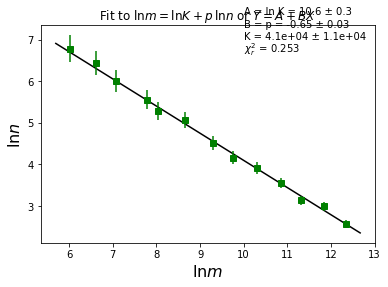

<Figure size 432x288 with 0 Axes>

In [3]:
import numpy as np
import matplotlib.pyplot as plt


def LineFitWt(x, y, sig):
    """ 
    Returns slope and y-intercept of weighted linear fit to
    (x,y) data set.
    Inputs: x and y data array and uncertainty array (unc)
            for y data set.
    Outputs: slope and y-intercept of best fit to data and
             uncertainties of slope & y-intercept.
    """
    sig2 = sig ** 2
    norm = (1.0 / sig2).sum()
    xhat = (x / sig2).sum() / norm
    yhat = (y / sig2).sum() / norm
    slope = ((x - xhat) * y / sig2).sum() / ((x - xhat) * x / sig2).sum()
    yint = yhat - slope * xhat
    sig2_slope = 1.0 / ((x - xhat) * x / sig2).sum()
    sig2_yint = sig2_slope * (x * x / sig2).sum() / norm
    return slope, yint, np.sqrt(sig2_slope), np.sqrt(sig2_yint)


def redchisq(x, y, dy, slope, yint):
    chisq = (((y - yint - slope * x) / dy) ** 2).sum()
    return chisq / float(x.size - 2)


# Read data from data file
n, m, dm = np.loadtxt("data/Mass.txt", skiprows=4, unpack=True)

########## Code to tranform & fit data starts here ##########

# Transform data and parameters to linear form: Y = A + B*X
X = np.log(m)  # transform t data for fitting
Y = np.log(n)  # transform N data for fitting
dY = dm / m  # transform uncertainties for fitting

# Fit transformed data X, Y, dY to obtain fitting parameters
# B & A.  Also returns uncertainties dA & dB in B & A
B, A, dB, dA = LineFitWt(X, Y, dY)
# Return reduced chi-squared
redchisqr = redchisq(X, Y, dY, B, A)

# Determine fitting parameters for original exponential function
# N = N0 exp(-Gamma t) ...
p = B
K = np.exp(A)
# ... and their uncertainties
dp = dB
dK = np.exp(A) * dA

###### Code to plot transformed data and fit starts here ######

# Create line corresponding to fit using fitting parameters
# Only two points are needed to specify a straight line
Xext = 0.05 * (X.max() - X.min())
Xfit = np.array([X.min() - Xext, X.max() + Xext])
Yfit = B * Xfit + A  # generates Y from X data &
# fitting function
plt.errorbar(X, Y, dY, fmt="gs")
plt.plot(Xfit, Yfit, "k-", zorder=-1)
plt.title(r"Fit to $\ln m=\ln K + p\, \ln n$ or $Y=A+BX$")
plt.xlabel(r"$\ln m$", fontsize=16)
plt.ylabel(r"$\ln n$", fontsize=16)

plt.text(10, 7.6, u"A = ln K = {0:0.1f} \xb1 {1:0.1f}".format(A, dA))
plt.text(10, 7.3, u"B = p = {0:0.2f} \xb1 {1:0.2f}".format(B, dB))
plt.text(10, 7.0, u"K = {0:0.1e} \xb1 {1:0.1e}".format(K, dK))
plt.text(10, 6.7, "$\chi_r^2$ = {0:0.3f}".format(redchisqr))

plt.show()
plt.savefig("Mass.pdf")

${\large\bf 3.}$ (a)

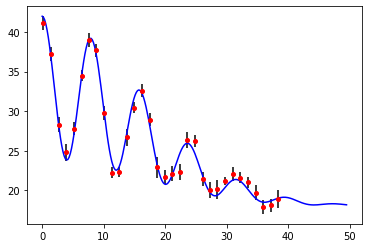

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# define function to calculate reduced chi-squared
def RedChiSqr(func, x, y, dy, params):
    resids = y - func(x, *params)
    chisq = ((resids / dy) ** 2).sum()
    return chisq / float(x.size - params.size)


# define fitting function
def oscDecay(t, A, B, C, tau, omega):
    y = A * (1.0 + B * np.cos(omega * t)) * np.exp(-0.5 * t * t / (tau * tau)) + C
    return y


# read in spectrum from data file
t, decay, unc = np.loadtxt("data/oscDecayData.txt", skiprows=4, unpack=True)

# initial values for fitting parameters (guesses)
A0 = 15.0
B0 = 0.6
C0 = 1.2 * A0
tau0 = 16.0
omega0 = 2.0 * np.pi / 8.0  # period of oscillations in data is about 8

# plot data and fit with estimated fitting parameters

tFit = np.linspace(0.0, 49.5, 250)
plt.plot(tFit, oscDecay(tFit, A0, B0, C0, tau0, omega0), "b-")
plt.errorbar(t, decay, yerr=unc, fmt="or", ecolor="black", ms=4)
plt.show()

(b)

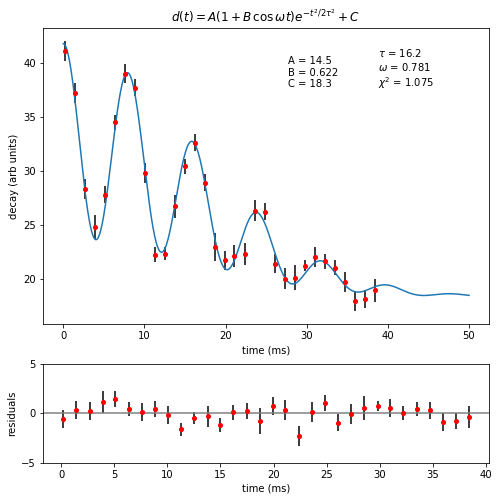

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec  # for unequal plot boxes
import scipy.optimize

# define function to calculate reduced chi-squared
def RedChiSqr(func, x, y, dy, params):
    resids = y - func(x, *params)
    chisq = ((resids / dy) ** 2).sum()
    return chisq / float(x.size - params.size)


# define fitting function
def oscDecay(t, A, B, C, tau, omega):
    y = A * (1.0 + B * np.cos(omega * t)) * np.exp(-0.5 * t * t / (tau * tau)) + C
    return y


# read in spectrum from data file
t, decay, unc = np.loadtxt("data/oscDecayData.txt", skiprows=4, unpack=True)

# initial values for fitting parameters (guesses)
A0 = 15.0
B0 = 0.6
C0 = 1.2 * A0
tau0 = 16.0
omega0 = 2.0 * np.pi / 8.0

# fit data using SciPy's Levenberg-Marquart method
nlfit, nlpcov = scipy.optimize.curve_fit(
    oscDecay, t, decay, p0=[A0, B0, C0, tau0, omega0], sigma=unc
)

# calculate reduced chi-squared
rchi = RedChiSqr(oscDecay, t, decay, unc, nlfit)

# create fitting function from fitted parameters
A, B, C, tau, omega = nlfit
t_fit = np.linspace(0.0, 50.0, 512)
d_fit = oscDecay(t_fit, A, B, C, tau, omega)

# Create figure window to plot data
fig = plt.figure(1, figsize=(8, 8))  # extra length for residuals
gs = gridspec.GridSpec(2, 1, height_ratios=[6, 2])

# Top plot: data and fit
ax1 = fig.add_subplot(gs[0])
ax1.plot(t_fit, d_fit)
ax1.errorbar(t, decay, yerr=unc, fmt="or", ecolor="black", ms=4)
ax1.set_xlabel("time (ms)")
ax1.set_ylabel("decay (arb units)")
ax1.text(
    0.55,
    0.8,
    "A = {0:0.1f}\nB = {1:0.3f}\nC = {2:0.1f}".format(A, B, C),
    transform=ax1.transAxes,
)
ax1.text(
    0.75,
    0.8,
    "$\\tau$ = {0:0.1f}\n$\omega$ = {1:0.3f}\n$\chi^2$ = {2:0.3f}".format(
        tau, omega, rchi
    ),
    transform=ax1.transAxes,
)
ax1.set_title("$d(t) = A (1+B\,\cos\,\omega t) e^{-t^2/2\\tau^2} + C$")

# Bottom plot: residuals
resids = decay - oscDecay(t, A, B, C, tau, omega)
ax2 = fig.add_subplot(gs[1])
ax2.axhline(color="gray")
ax2.errorbar(t, resids, yerr=unc, ecolor="black", fmt="ro", ms=4)
ax2.set_xlabel("time (ms)")
ax2.set_ylabel("residuals")
ax2.set_ylim(-5, 5)
yticks = (-5, 0, 5)
ax2.set_yticks(yticks)

plt.savefig("FitOscDecay.pdf")

plt.show()

(c)

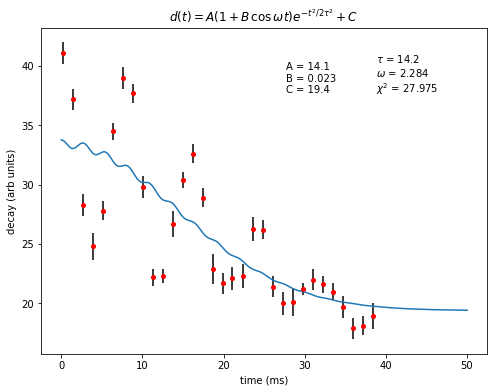

In [6]:
# initial values for fitting parameters (guesses)
A0 = 15.0
B0 = 0.6
C0 = 1.2 * A0
tau0 = 16.0
omega0 = 3.0 * 0.781

# fit data using SciPy's Levenberg-Marquart method
nlfit, nlpcov = scipy.optimize.curve_fit(
    oscDecay, t, decay, p0=[A0, B0, C0, tau0, omega0], sigma=unc
)

# calculate reduced chi-squared
rchi = RedChiSqr(oscDecay, t, decay, unc, nlfit)

# create fitting function from fitted parameters
A, B, C, tau, omega = nlfit
t_fit = np.linspace(0.0, 50.0, 512)
d_fit = oscDecay(t_fit, A, B, C, tau, omega)

# Create figure window to plot data
fig = plt.figure(1, figsize=(8, 6))

# Top plot: data and fit
ax1 = fig.add_subplot(111)
ax1.plot(t_fit, d_fit)
ax1.errorbar(t, decay, yerr=unc, fmt="or", ecolor="black", ms=4)
ax1.set_xlabel("time (ms)")
ax1.set_ylabel("decay (arb units)")
ax1.text(
    0.55,
    0.8,
    "A = {0:0.1f}\nB = {1:0.3f}\nC = {2:0.1f}".format(A, B, C),
    transform=ax1.transAxes,
)
ax1.text(
    0.75,
    0.8,
    "$\\tau$ = {0:0.1f}\n$\omega$ = {1:0.3f}\n$\chi^2$ = {2:0.3f}".format(
        tau, omega, rchi
    ),
    transform=ax1.transAxes,
)
ax1.set_title("$d(t) = A (1+B\,\cos\,\omega t) e^{-t^2/2\\tau^2} + C$")

plt.show()

(d) The program finds the optimal values for all the fitting paramters again

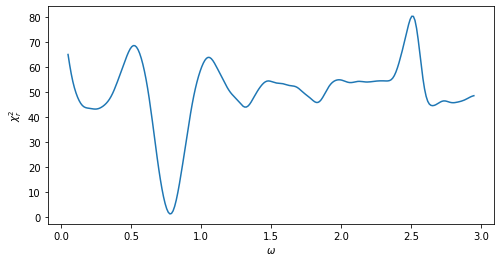

In [7]:
# initial values for fitting parameters (guesses)
A0 = 15.0
B0 = 0.6
C0 = 1.2 * A0
tau0 = 16.0
omega0 = 2.0 * np.pi / 8.0

# fit data using SciPy's Levenberg-Marquardt method
nlfit, nlpcov = scipy.optimize.curve_fit(
    oscDecay, t, decay, p0=[A0, B0, C0, tau0, omega0], sigma=unc
)

# unpack optimal values of fitting parameters from nlfit
A, B, C, tau, omega = nlfit

# calculate reduced chi square for different values around the optimal
omegaArray = np.linspace(0.05, 2.95, 256)
redchiArray = np.zeros(omegaArray.size)
for i in range(omegaArray.size):
    nlfit = np.array([A, B, C, tau, omegaArray[i]])
    redchiArray[i] = RedChiSqr(oscDecay, t, decay, unc, nlfit)

plt.figure(figsize=(8, 4))
plt.plot(omegaArray, redchiArray)
plt.xlabel("$\omega$")
plt.ylabel("$\chi_r^2$")

plt.savefig("VaryChiSq.pdf")

plt.show()